# Exploring Iterative Solve Results

This notebook explores the results of iterative training of a random forest classifier on migration edges to improve the model's costs and help it select the correct edges more frequently.

We investigate the effect on the metrics with increasing sample size provided to the classifier, as well as the change in costs with more training, and the distribution of edges being sampled at each iteration.

In [8]:
import os
import pandas as pd

initial_root = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint/'
ds_summary_path = os.path.join(initial_root, 'summary.csv')
ds_info = pd.read_csv(ds_summary_path)[['ds_name']]

iterative_root = '/home/ddon0001/PhD/experiments/iterative/'

skip_info = pd.read_csv(os.path.join(initial_root, 'skip_merges.csv'))
ds_info = ds_info.merge(skip_info, left_on='ds_name', right_on='ds_name', how='left')[['ds_name', 'total_skips']]


In [ ]:
# gathering info about each iteration for each dataset
# all cumulative
import json
import networkx as nx
import numpy as np
from experiment_schema import OUT_FILE


df_cols = [
    'ds_name',
    'iteration',
    # total number of edges in solution
    'total_sol_edges',
    # 'expected' wrong number of edges (fn nodes + num skip edges)
    'expected_wrong_edges',
    # 'expected' wrong edges as prop of all initial edge errors
    'expected_wrong_prop',
    # number of edges "presented to the user"
    'n_sol_edges_sampled',
    # proportion of all edges in solution "presented to the user"
    'prop_sol_edges_sampled',
    # number of all edges in model whose value has been fixed by user OR by deduction
    'n_all_edges_sampled',
    # proportion of all edges in model whose value has been fixed by user OR by deduction
    'prop_all_edges_sampled',
    # number of edges corrected (i.e. flow value changed) only through user information
    'n_manually_corrected_edges',
    # proportion of all edge errors corrected only through user information
    'prop_manually_corrected_edges',
    # number of FP edges remaining
    'n_fp_edges',
    # proportion of original FP edges remaining
    'prop_fp_edges',
    # number of FN edges remaining
    'n_fn_edges',
    # proportion of original FN edges remaining
    'prop_fn_edges',
    # number of WS edges remaining
    'n_ws_edges',
    # proportion of original WS edges remaining
    'prop_ws_edges',
    # number of edge errors in total remaining
    'total_edge_errors',
    # proportion of original edge errors remaining
    'prop_edge_errors',
    # AOGM
    'AOGM',
    # number of divisions in solution
    'n_divisions',
    # number of merges in solution
    'n_merges',
    # proportion of divisions in current solution vs initial solution
    'prop_divisions',
    # proportion of merges in current solution vs initial solution
    'prop_merges'
]
data = {col: [] for col in df_cols}


for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_out_root = os.path.join(iterative_root, ds_name)
    ds_init_root = os.path.join(initial_root, ds_name)
    if not os.path.exists(ds_out_root) or ds_name in ['Fluo-C3DH-H157_02', 'Fluo-C3DH-A549_01', 'Fluo-C3DH-A549_02']:
        print("Solution not present ", ds_name)
        continue

    with open(os.path.join(ds_out_root, 'sampling_strategy.txt'), 'r') as f:
        sampling_strat = [int(line) for line in f]
    solution_graph = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_SOL.value), node_type=int)
    sol_cum_sampled = np.cumsum(sampling_strat)

    data['ds_name'].append(ds_name)
    data['total_sol_edges'].append(solution_graph.number_of_edges())
    data['iteration'].append(0)
    data['n_sol_edges_sampled'].append(0)
    data['prop_sol_edges_sampled'].append(0)
    data['n_all_edges_sampled'].append(0)
    data['prop_all_edges_sampled'].append(0)
    data['n_manually_corrected_edges'].append(0)
    data['prop_manually_corrected_edges'].append(0)

    with open(os.path.join(ds_init_root, OUT_FILE.METRICS.value), 'r') as f:
        metrics = json.load(f)
    data['n_fp_edges'].append(metrics['fp_edges'])
    data['prop_fp_edges'].append(1)
    data['n_fn_edges'].append(metrics['fn_edges'])
    data['prop_fn_edges'].append(1)
    data['n_ws_edges'].append(metrics['ws_edges'])
    data['prop_ws_edges'].append(1)

    all_edges_before_it = pd.read_csv(os.path.join(ds_init_root, OUT_FILE.ALL_EDGES.value))
    init_n_all_edges = len(all_edges_before_it)
    init_n_sol_edges = solution_graph.number_of_edges()
    init_n_fp_edges = metrics['fp_edges']
    init_n_fn_edges = metrics['fn_edges']
    init_n_ws_edges = metrics['ws_edges']
    
    total_init = (init_n_fp_edges + init_n_fn_edges + init_n_ws_edges)
    expected_wrong_edges = metrics['fn_nodes'] + row['total_skips']
    expected_wrong_prop = expected_wrong_edges / total_init if total_init != 0 else 0
    data['expected_wrong_edges'].append(expected_wrong_edges)
    data['expected_wrong_prop'].append(expected_wrong_prop)
    data['total_edge_errors'].append(total_init)
    data['prop_edge_errors'].append(1)
    data['AOGM'].append(metrics['AOGM'])

    starting_divisions = len([n for n in solution_graph.nodes if solution_graph.out_degree(n) > 1])
    starting_merges = len([n for n in solution_graph.nodes if solution_graph.in_degree(n) > 1])
    data['n_divisions'].append(starting_divisions)
    data['n_merges'].append(starting_merges)
    data['prop_divisions'].append(1)
    data['prop_merges'].append(1)


    print("#" * 60)
    print("Looking at ", ds_name)
    for i, it in enumerate(range(1, len(sampling_strat))):
        if not os.path.exists(os.path.join(ds_out_root, f'{ds_name}_it{it}')):
            print(f"Missing iteration {it}")
            continue
        data['ds_name'].append(ds_name)
        data['total_sol_edges'].append(solution_graph.number_of_edges())
        data['iteration'].append(it)
        data['n_sol_edges_sampled'].append(sol_cum_sampled[i])
        data['prop_sol_edges_sampled'].append(sol_cum_sampled[i] / init_n_sol_edges)

        all_edges_after_it = pd.read_csv(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.ALL_EDGES.value))
        with open(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.METRICS.value), 'r') as f:
            metrics_after_it = json.load(f)
        sampled_before_now = all_edges_after_it[all_edges_after_it['sampled'] == 1]
        n_sampled = len(sampled_before_now)
        data['n_all_edges_sampled'].append(n_sampled)
        data['prop_all_edges_sampled'].append(n_sampled / init_n_all_edges)
        n_man_corr = len(sampled_before_now[sampled_before_now.manually_repaired == 1])
        # each man correct edge corrects 1 ws and 1 fp edge - we present this as proportion of all initial edge errors
        prop_man_corr = (2 * n_man_corr) / total_init if total_init != 0 else 0
        data['n_manually_corrected_edges'].append(2 * n_man_corr)
        data['prop_manually_corrected_edges'].append(prop_man_corr)

        rem_fp = metrics_after_it['fp_edges']
        rem_fn = metrics_after_it['fn_edges']
        rem_ws = metrics_after_it['ws_edges']
        total_rem = rem_fp + rem_fn + rem_ws
        expected_wrong_edges = metrics_after_it['fn_nodes'] + row['total_skips']
        expected_wrong_prop = expected_wrong_edges / total_init if total_init != 0 else 0

        data['n_fp_edges'].append(rem_fp)
        data['prop_fp_edges'].append(rem_fp / init_n_fp_edges if init_n_fp_edges != 0 else 0)
        data['n_fn_edges'].append(rem_fn)
        data['prop_fn_edges'].append(rem_fn / init_n_fn_edges if init_n_fn_edges != 0 else 0)
        data['n_ws_edges'].append(rem_ws)
        data['prop_ws_edges'].append(rem_ws / init_n_ws_edges if init_n_ws_edges != 0 else 0)
        data['total_edge_errors'].append(total_rem)
        data['prop_edge_errors'].append(total_rem / total_init if total_init != 0 else 0)
        data['expected_wrong_edges'].append(expected_wrong_edges)
        data['expected_wrong_prop'].append(expected_wrong_prop)
        data['AOGM'].append(metrics_after_it['AOGM'])

        solution_graph = nx.read_graphml(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.MATCHED_SOL.value), node_type=int)
        n_div = len([n for n in solution_graph.nodes if solution_graph.out_degree(n) > 1])
        n_merg = len([n for n in solution_graph.nodes if solution_graph.in_degree(n) > 1])
        data['n_divisions'].append(n_div)
        data['n_merges'].append(n_merg)
        data['prop_divisions'].append(n_div / starting_divisions if starting_divisions != 0 else 0)
        data['prop_merges'].append(n_merg / starting_merges if starting_merges != 0 else 0)
iter_df = pd.DataFrame(data)

In [3]:
iter_df = pd.read_csv(os.path.join(iterative_root, 'iteration_summary.csv'))

In [3]:
starting_edge_errors = iter_df[iter_df['iteration'] == 0][['ds_name', 'total_edge_errors']]
starting_edge_errors.sort_values(by='total_edge_errors', ascending=False, inplace=True)
plot_ds_name_order = starting_edge_errors.ds_name.unique().tolist()

In [4]:
cols_to_melt = [col for col in iter_df.columns if 'prop'  in col]
cols_to_keep = ['ds_name', 'iteration', 'n_sol_edges_sampled']
iter_melted = iter_df.melt(id_vars=cols_to_keep, value_vars=cols_to_melt, var_name='category', value_name='proportion')

In [ ]:
iter_melted.category.unique()

In [17]:
remaining_errors_cols = [
    'prop_sol_edges_sampled',
    'expected_wrong_prop',
    'prop_manually_corrected_edges',
    # 'prop_fp_edges', 
    # 'prop_fn_edges',
    # 'prop_ws_edges',
    'prop_edge_errors'
]
iter_melted = iter_df.melt(id_vars=cols_to_keep, value_vars=remaining_errors_cols, var_name='category', value_name='proportion')

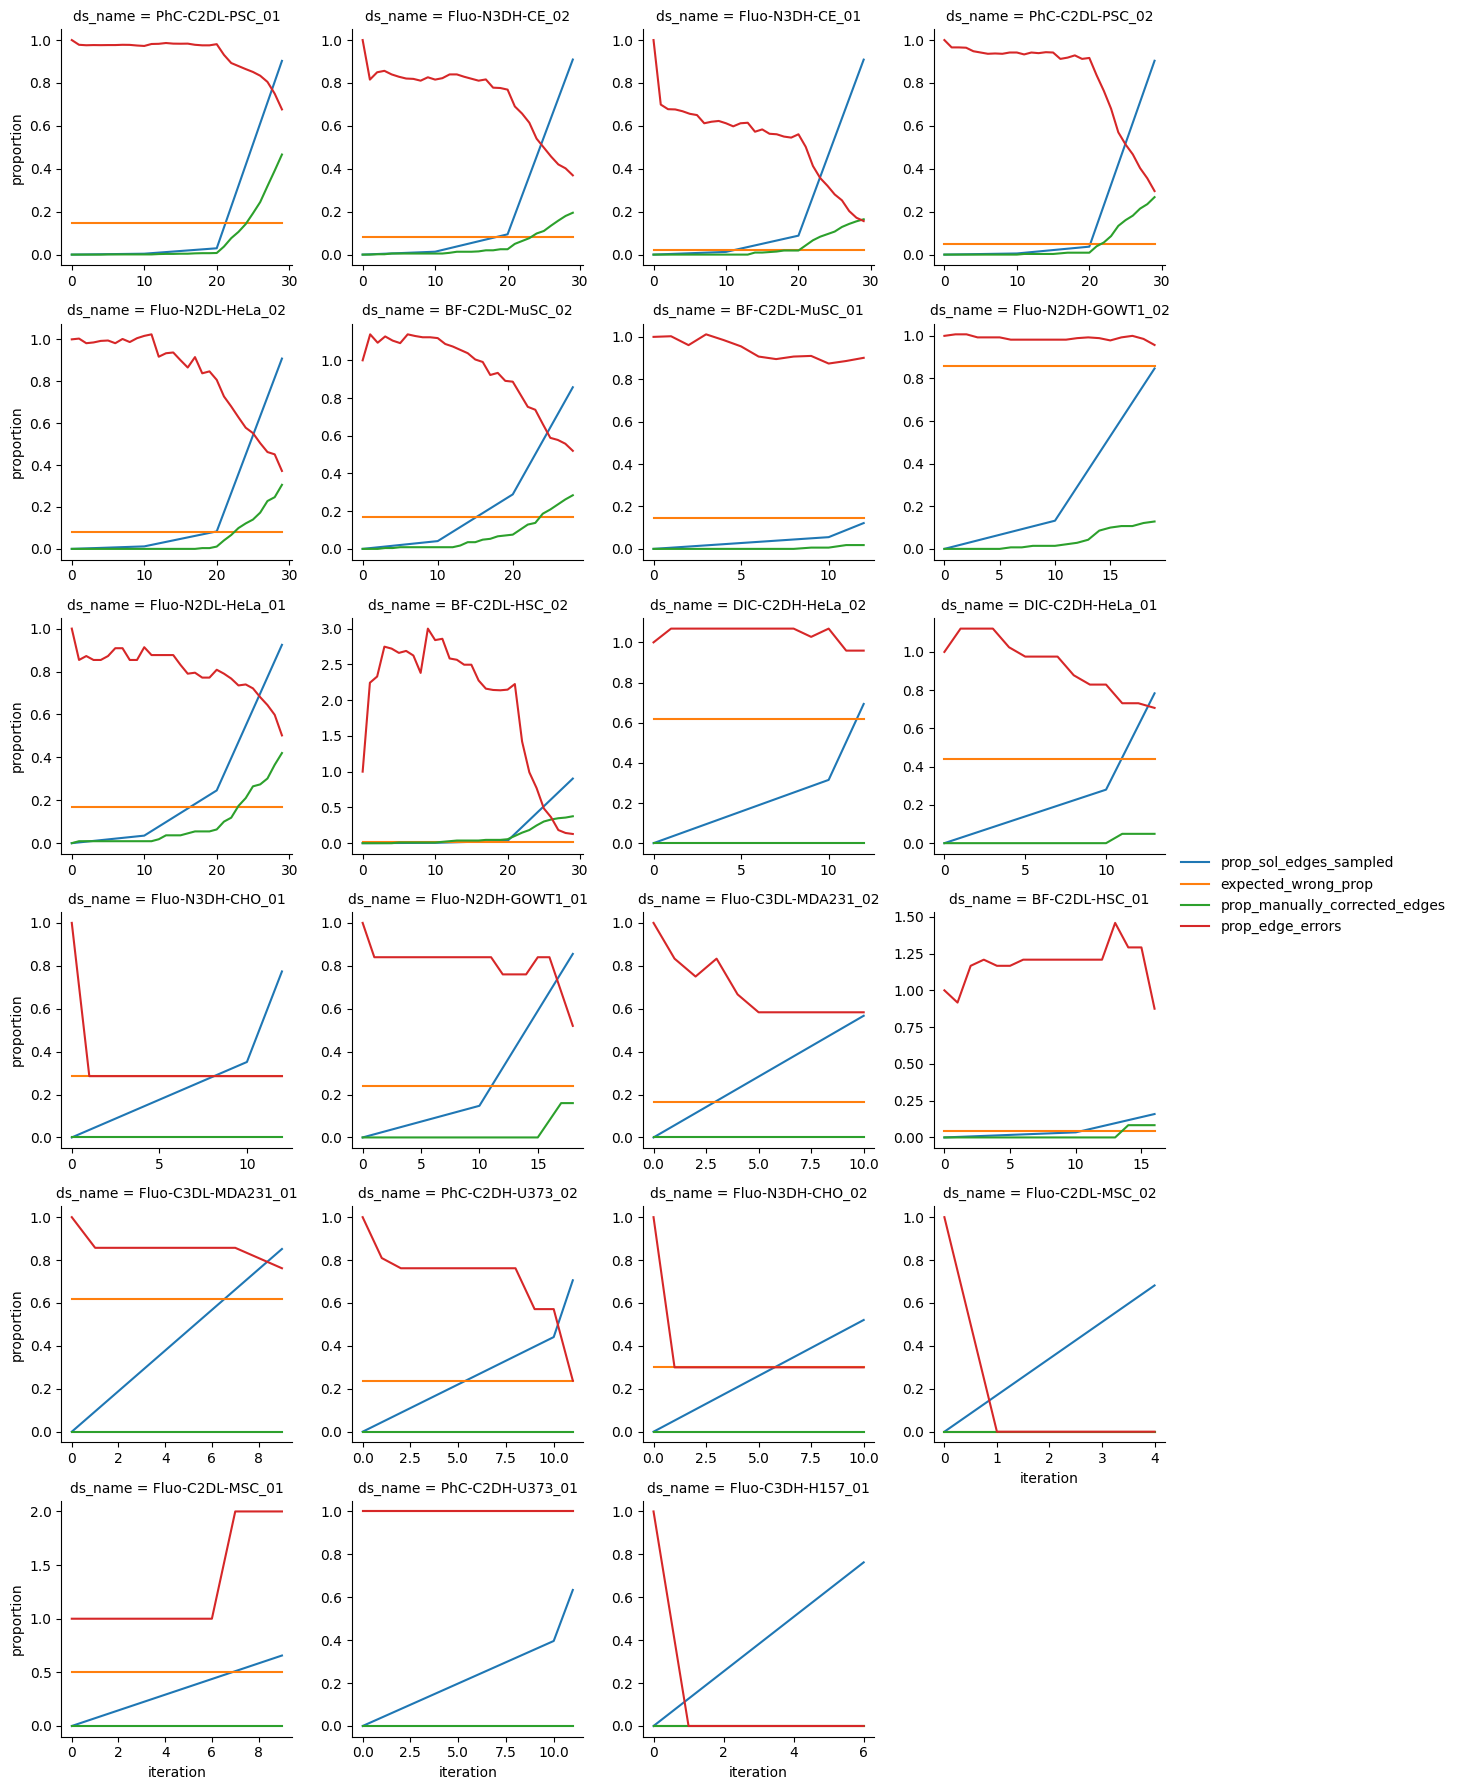

In [18]:
import seaborn as sns

grid = sns.FacetGrid(iter_melted, col='ds_name', col_order=plot_ds_name_order, col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='iteration', y='proportion', hue='category')
grid.add_legend()

In [ ]:
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

ds_names_with_many_errors = starting_edge_errors[starting_edge_errors.total_edge_errors >= 30].sort_values(by='total_edge_errors').ds_name.unique().tolist()
many_error_df = iter_df[iter_df.ds_name.isin(ds_names_with_many_errors)]
many_error_df = many_error_df.rename(columns={'ds_name': 'dataset'})[['dataset', 'iteration', 'prop_edge_errors']]
many_error_df = many_error_df.merge(starting_edge_errors, how='left', left_on='dataset', right_on='ds_name')

iter_medians = {
    'dataset': [],
    'iteration': [],
    'prop_edge_errors': [],
    'total_edge_errors': []
    
}
for it in many_error_df.iteration.unique():
    iter_medians['dataset'].append('median')
    iter_medians['iteration'].append(it)
    iter_medians['prop_edge_errors'].append(many_error_df[many_error_df.iteration == it].prop_edge_errors.median())
    iter_medians['total_edge_errors'].append(0)

error_median_df = pd.concat([many_error_df, pd.DataFrame(iter_medians)], ignore_index=True)
error_median_df['category'] = error_median_df['dataset'].apply(lambda x: 'median' if x == 'median' else 'individual')
a4_dims = (5.5, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.axhline(y = 1,    # Line on x = 2
        xmin = 0, # Bottom of the plot
        xmax = 30, # Top of the plot
        color='black'
        )
lplt = sns.lineplot(error_median_df[error_median_df['dataset'] != 'median'], ax=ax, x='iteration', y='prop_edge_errors', hue='total_edge_errors', hue_norm=matplotlib.colors.LogNorm(), palette='Blues', estimator=None, alpha=0.7)
sns.lineplot(error_median_df[error_median_df['dataset'] == 'median'], ax=ax, x='iteration', y='prop_edge_errors', estimator=None)
# sns.move_legend(lplt, "upper left", bbox_to_anchor=(1, 1))
custom_lines = [Line2D([0], [0], color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), lw=2),
                Line2D([0], [0], color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), lw=2)]

ax.legend(custom_lines, ['Individual Dataset', 'Median'])
ax.set_title('Proportion of Original Errors Remaining \nAfter Each Learning Iteration')
ax.set_ylabel('error proportion')
ax.set_ylim(0, 1.3)

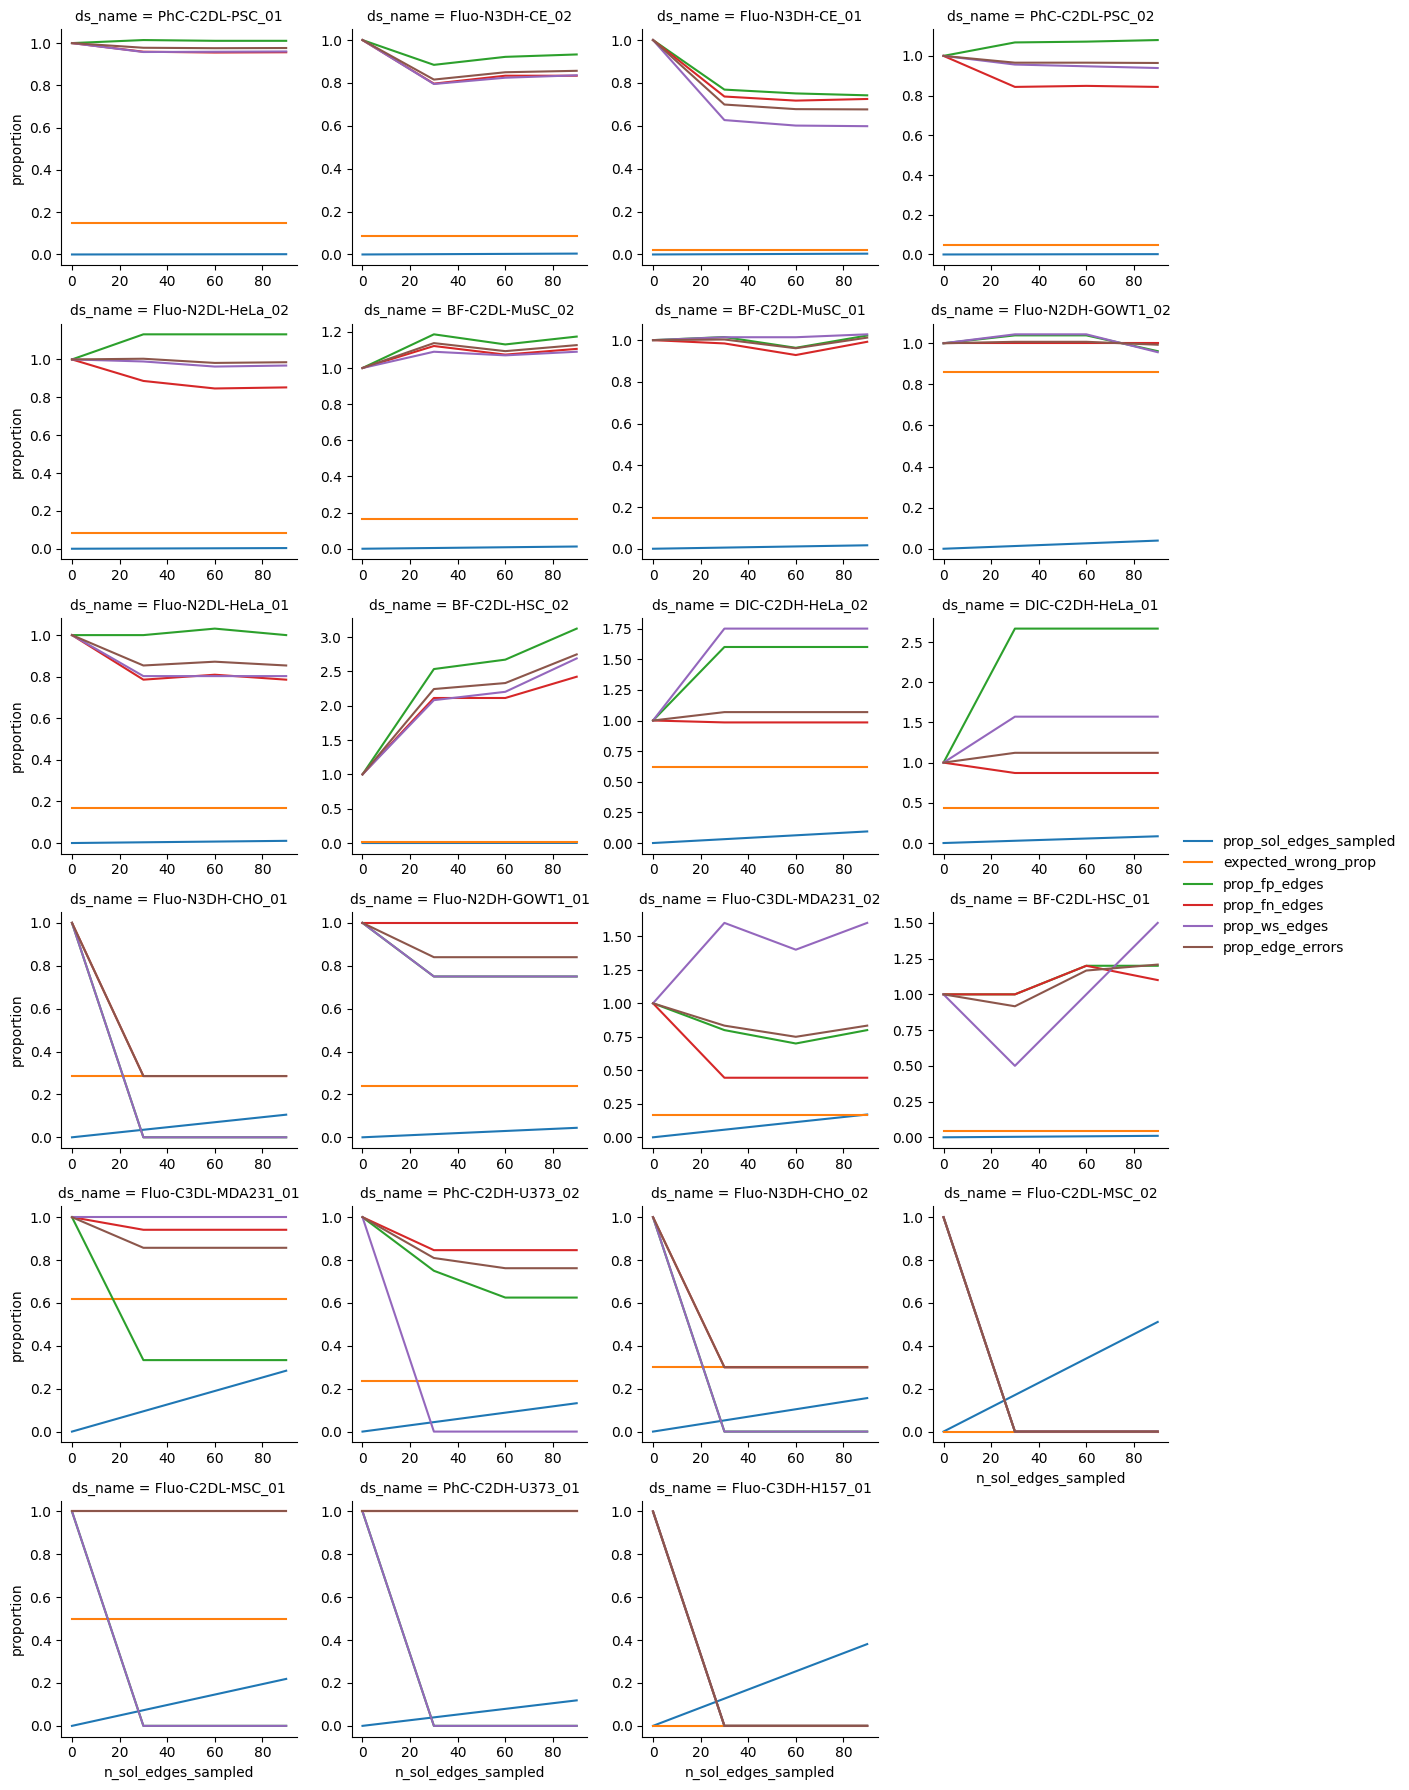

In [8]:
import seaborn as sns

remaining_errors_cols = [
    'prop_sol_edges_sampled',
    'expected_wrong_prop',
    # 'prop_manually_corrected_edges',
    'prop_fp_edges', 
    'prop_fn_edges',
    'prop_ws_edges',
    'prop_edge_errors'
]
cols_to_keep = ['ds_name', 'n_sol_edges_sampled']
iter_up_close = iter_df[iter_df.n_sol_edges_sampled <= 100].melt(id_vars=cols_to_keep, value_vars=remaining_errors_cols, var_name='category', value_name='proportion')

grid = sns.FacetGrid(iter_up_close, col='ds_name', col_order=plot_ds_name_order, col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='n_sol_edges_sampled', y='proportion', hue='category')
grid.add_legend()

In [ ]:
import seaborn as sns

remaining_errors_cols = [
    # 'prop_sol_edges_sampled',
    # 'expected_wrong_prop',
    # 'n_divisions',
    # 'n_merges',
    # 'total_edge_errors',
    # 'n_fp_edges',
    # 'n_ws_edges',
    # 'n_fn_edges'
    # 'prop_manually_corrected_edges',
    # 'prop_fp_edges', 
    # 'prop_fn_edges',
    # 'prop_ws_edges',
    'prop_edge_errors',
    'prop_divisions',
    'prop_merges'
]
cols_to_keep = ['ds_name', 'prop_sol_edges_sampled']
iter_up_close = iter_df.melt(id_vars=cols_to_keep, value_vars=remaining_errors_cols, var_name='event', value_name='count')

grid = sns.FacetGrid(iter_up_close, col='ds_name', col_order=plot_ds_name_order, col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='prop_sol_edges_sampled', y='count', hue='event')
grid.add_legend()

In [5]:
# gathering info about each iteration for each dataset
import json
import networkx as nx
import numpy as np
from experiment_schema import OUT_FILE


# we want to know the what the migration probability looks like for the two children of correct divisions vs.
# incorrect divisions
# look at difference in mig proba between two closest children and also at difference in mig proba between
# average of two closest children (?) and most probable not chosen child?
# look at mig proba vs. neighbour rank after iter 1 - how many incorrect divs are we really risking?

ds_names = []
its = []
prop_solution_correct = []
prop_all_edges_correct = []
prop_presented_correct = []
prop_sampled_correct = []

for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_out_root = os.path.join(iterative_root, ds_name)
    ds_init_root = os.path.join(initial_root, ds_name)
    if not os.path.exists(ds_out_root):
        print("Solution not present ", ds_name)
        continue

    with open(os.path.join(ds_out_root, 'sampling_strategy.txt'), 'r') as f:
        sampling_strat = [int(line) for line in f]
    solution_graph = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_SOL.value), node_type=int)


    with open(os.path.join(ds_init_root, OUT_FILE.METRICS.value), 'r') as f:
        metrics = json.load(f)

    all_edges_before_it = pd.read_csv(os.path.join(ds_init_root, OUT_FILE.ALL_EDGES.value))
    
    n_sol_edges = solution_graph.number_of_edges()
    n_correct = n_sol_edges - metrics['fp_edges']
    prop_correct = n_correct / n_sol_edges

    n_all_edges = len(all_edges_before_it)
    prop_all_correct = n_correct / n_all_edges

    n_sampled_correct_prop = 0
    all_edges_correct_prop = 0

    ds_names.append(ds_name)
    its.append(0)
    prop_solution_correct.append(prop_correct)
    prop_all_edges_correct.append(prop_all_correct)
    prop_presented_correct.append(0)
    prop_sampled_correct.append(0)
    print("Looking at ", ds_name)
    for i, it in enumerate(range(1, len(sampling_strat))):
        if not os.path.exists(os.path.join(ds_out_root, f'{ds_name}_it{it}')):
            continue
        
        all_edges_after_it = pd.read_csv(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.ALL_EDGES.value))
        sol_after_it = nx.read_graphml(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.MATCHED_SOL.value), node_type=int)
        with open(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.METRICS.value), 'r') as f:
            metrics_after_it = json.load(f)

        n_sol_edges = sol_after_it.number_of_edges()
        n_correct = n_sol_edges - metrics_after_it['fp_edges']
        prop_correct = n_correct / n_sol_edges

        n_all_edges = len(all_edges_after_it)
        prop_all_correct = n_correct / n_all_edges

        presented_to_user_correct = 0
        presented_to_user_incorrect = 0
        sampled_then = all_edges_after_it[all_edges_after_it.sampled_it == it]
        for _, row in sampled_then.iterrows():
            u = row['u']
            v = row['v']
            eoi = all_edges_before_it[(all_edges_before_it.u == u) & (all_edges_before_it.v == v)]
            if eoi['flow'].sum() > 0 and row['manually_repaired'] < 0:
                is_correct = eoi['oracle_is_correct'].values[0] if 'oracle_is_correct' in eoi else row['oracle_is_correct']
                if is_correct:
                    presented_to_user_correct += 1
                else:
                    presented_to_user_incorrect += 1

        presented_correct_prop = presented_to_user_correct / (presented_to_user_correct + presented_to_user_incorrect)
        sampled_correct_prop = sampled_then['oracle_is_correct'].sum() / len(sampled_then)

        ds_names.append(ds_name)
        its.append(it)
        prop_solution_correct.append(prop_correct)
        prop_all_edges_correct.append(prop_all_correct)
        prop_presented_correct.append(presented_correct_prop)
        prop_sampled_correct.append(sampled_correct_prop)

        all_edges_before_it = all_edges_after_it
sampled_df = pd.DataFrame({
    'ds_names': ds_names,
    'it': its,
    'prop_solution_correct': prop_solution_correct,
    'prop_all_edges_correct': prop_all_edges_correct,
    'prop_presented_correct': prop_presented_correct,
    'prop_sampled_correct': prop_sampled_correct
})
        

Looking at  Fluo-C3DL-MDA231_01
Looking at  Fluo-C3DL-MDA231_02
Looking at  Fluo-N2DH-GOWT1_01
Looking at  Fluo-N2DH-GOWT1_02
Looking at  PhC-C2DH-U373_01
Looking at  PhC-C2DH-U373_02
Looking at  Fluo-N2DL-HeLa_01
Looking at  Fluo-N2DL-HeLa_02
Looking at  Fluo-C2DL-MSC_01
Looking at  Fluo-C2DL-MSC_02
Looking at  Fluo-C3DH-H157_01
Solution not present  Fluo-C3DH-H157_02
Looking at  DIC-C2DH-HeLa_01
Looking at  DIC-C2DH-HeLa_02
Looking at  Fluo-N3DH-CHO_01
Looking at  Fluo-N3DH-CHO_02
Looking at  BF-C2DL-MuSC_01
Looking at  BF-C2DL-MuSC_02
Looking at  BF-C2DL-HSC_01
Looking at  BF-C2DL-HSC_02
Looking at  Fluo-C3DH-A549_01
Looking at  Fluo-C3DH-A549_02
Looking at  PhC-C2DL-PSC_01
Looking at  PhC-C2DL-PSC_02
Looking at  Fluo-N3DH-CE_01
Looking at  Fluo-N3DH-CE_02


In [4]:
# scatter plot of mig proba of correct children vs. incorrect children, all divs
# after first iteration
import networkx as nx
from experiment_schema import OUT_FILE

ds_names = []
parent_id = []
divs_correct = []
child_id  = []
child_mig_proba = []

for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_init_root = os.path.join(initial_root, ds_name)
    ds_out_root = os.path.join(iterative_root, ds_name)
    first_it_root = os.path.join(ds_out_root, f'{ds_name}_it1')
    if not os.path.exists(ds_out_root) or not os.path.exists(first_it_root):
        print("Solution not present ", ds_name)
        continue
    # load all_edges after iteration, so we can see what mig_predict_probas we got
    all_edges_before_it = pd.read_csv(os.path.join(first_it_root, OUT_FILE.ALL_EDGES.value))
    # load ORIGINAL solution with divisions - can we trust the new mig probas?
    orig_matched_sol = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_SOL.value), node_type=int)
    for node_id, degree in nx.degree(orig_matched_sol):
        if degree > 1:
            children = list(orig_matched_sol.successors(node_id))
            for child in children:
                ds_names.append(ds_name)
                parent_id.append(node_id)
                child_id.append(child)
                child_mig_proba.append(all_edges_before_it[(all_edges_before_it.u == node_id) & (all_edges_before_it.v == child)]['mig_predict_proba'].values[0])
                edge_info = orig_matched_sol.edges[node_id, child]
                div_correct = not (edge_info['EdgeFlag.FALSE_POS'] or edge_info['EdgeFlag.WRONG_SEMANTIC'])
                divs_correct.append(div_correct)
div_df = pd.DataFrame({
    'ds_name': ds_names,
    'parent_id': parent_id,
    'child_id': child_id,
    'child_mig_proba': child_mig_proba,
    'div_correct': divs_correct
})

            

Solution not present  Fluo-C3DH-H157_02
Solution not present  Fluo-C3DH-A549_01
Solution not present  Fluo-C3DH-A549_02


In [ ]:
import seaborn as sns

id_cols = ['ds_names', 'it']
val_cols = ['prop_solution_correct', 'prop_all_edges_correct', 'prop_presented_correct', 'prop_sampled_correct']
sampled_df_melted = sampled_df.melt(id_vars=id_cols, value_vars=val_cols, var_name='category', value_name='proportion')
plot_order = div_df['ds_name'].value_counts().sort_values(ascending=False).index.tolist()
grid = sns.FacetGrid(sampled_df_melted, col='ds_names', col_order=plot_order, col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='category')
grid.map_dataframe(sns.lineplot, x='it', y='proportion')
grid.add_legend()

In [ ]:
import seaborn as sns
plot_order = div_df['ds_name'].value_counts().sort_values(ascending=False).index.tolist()
grid = sns.FacetGrid(div_df[div_df.div_correct == True], col='ds_name', col_order=plot_order, col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='div_correct')
grid.map_dataframe(sns.histplot, x='child_mig_proba')
grid.add_legend()

In [ ]:
import seaborn as sns
plot_order = div_df['ds_name'].value_counts().sort_values(ascending=False).index.tolist()
grid = sns.FacetGrid(div_df[div_df.div_correct == False], col='ds_name', col_order=plot_order, col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='div_correct')
grid.map_dataframe(sns.histplot, x='child_mig_proba')
grid.add_legend()

In [4]:
# looking at divisions we've missed now i.e. any division in gt with at least 1 fn edge adjacent
from collections import defaultdict
import json
import networkx as nx
from experiment_schema import OUT_FILE

ds_names = []
parent_id = []
child_id  = []
child_mig_proba = []
edge_missing = []

count_node_not_present = defaultdict(lambda: 0)
count_edge_not_present = defaultdict(lambda: 0)
for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_init_root = os.path.join(initial_root, ds_name)
    ds_out_root = os.path.join(iterative_root, ds_name)
    first_it_root = os.path.join(ds_out_root, f'{ds_name}_it1')
    if not os.path.exists(ds_out_root) or not os.path.exists(first_it_root):
        print("Solution not present ", ds_name)
        continue
    # load all_edges after iteration, so we can see what mig_predict_probas we got
    all_edges_before_it = pd.read_csv(os.path.join(first_it_root, OUT_FILE.ALL_EDGES.value))
    # load ORIGINAL GT solution with divisions - can we trust the new mig probas?
    orig_gt_sol = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_GT.value))
    with open(os.path.join(ds_init_root, OUT_FILE.MATCHING.value), 'r') as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}
    for node_id, degree in nx.degree(orig_gt_sol):
        if degree > 1:
            children = list(orig_gt_sol.successors(node_id))
            # any fn edges?
            is_missing_div = False
            for child in children:
                if orig_gt_sol.edges[node_id, child]['EdgeFlag.FALSE_NEG']:
                    is_missing_div = True
            if is_missing_div:
                for child in children:
                    if node_id in gt_to_sol and child in gt_to_sol:
                        sol_parent = gt_to_sol[node_id]
                        sol_child = gt_to_sol[child]
                        eoi = all_edges_before_it[(all_edges_before_it.u == sol_parent) & (all_edges_before_it.v == sol_child)]
                        if len(eoi):
                            ds_names.append(ds_name)
                            parent_id.append(sol_parent)
                            child_id.append(sol_child)
                            child_mig_proba.append(eoi['mig_predict_proba'].values[0])
                            edge_missing.append(orig_gt_sol.edges[node_id, child]['EdgeFlag.FALSE_NEG'])
                        else:
                            count_edge_not_present[ds_name] += 1
                    else:
                        count_node_not_present[ds_name] += 1
missing_div_df = pd.DataFrame({
    'ds_name': ds_names,
    'parent_id': parent_id,
    'child_id': child_id,
    'child_mig_proba': child_mig_proba,
    'edge_missing': edge_missing
})



Solution not present  Fluo-C3DH-H157_02
Solution not present  Fluo-C3DH-A549_01
Solution not present  Fluo-C3DH-A549_02


In [19]:
# looking at edges in the GT solution that are not present in THE MODEL
import networkx as nx
import pandas as pd
from collections import defaultdict


missing_edges = defaultdict(list)
ds_names = []
n_edges = []
for _, row in ds_info.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(initial_root, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(initial_root, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(initial_root, ds_name, 'matching.json')
    all_edge_path = os.path.join(initial_root, ds_name, 'all_edges.csv')
    
    gt_g = nx.read_graphml(gt_solution_path)
    sol_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edge_path)
    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}
    
    # for each edge in gt
    for u, v in gt_g.edges:
    # if both vertices are present in solution_graph
        if u in gt_to_sol and v in gt_to_sol:
            sol_u = gt_to_sol[u]
            sol_v = gt_to_sol[v]
            model_edge = all_edges[(all_edges.u == gt_to_sol[u]) & (all_edges.v == gt_to_sol[v])]
            # but not present in all_edges
            if model_edge.empty:
                # append both vertices to missing_edges['ds_name']
                missing_edges[ds_name].append((sol_u, sol_v))
    ds_names.append(ds_name)
    n_edges.append(len(missing_edges[ds_name]))
print(missing_edges)


defaultdict(<class 'list'>, {'Fluo-C3DL-MDA231_01': [], 'Fluo-C3DL-MDA231_02': [(170, 272)], 'Fluo-N2DH-GOWT1_01': [(378, 493), (1757, 1929)], 'Fluo-N2DH-GOWT1_02': [], 'PhC-C2DH-U373_01': [(151, 344)], 'PhC-C2DH-U373_02': [(494, 545), (21, 77), (119, 135), (171, 190), (366, 427)], 'Fluo-N2DL-HeLa_01': [], 'Fluo-N2DL-HeLa_02': [(19383, 19735), (19735, 20086), (22981, 23344), (22349, 22711), (22711, 23073), (21394, 24288), (18171, 21034), (8428, 9286)], 'Fluo-C2DL-MSC_01': [], 'Fluo-C2DL-MSC_02': [], 'Fluo-C3DH-H157_01': [], 'Fluo-C3DH-H157_02': [(76, 82), (71, 77), (81, 113), (117, 130), (31, 70), (70, 85), (38, 45)], 'DIC-C2DH-HeLa_01': [(974, 1007)], 'DIC-C2DH-HeLa_02': [(814, 930), (832, 934), (274, 314)], 'Fluo-N3DH-CHO_01': [(281, 310), (281, 320), (248, 275), (256, 283), (256, 356), (505, 546), (436, 484), (436, 485), (689, 828), (689, 829)], 'Fluo-N3DH-CHO_02': [(97, 110), (97, 111), (157, 178), (157, 179), (399, 447), (399, 448)], 'BF-C2DL-MuSC_01': [(1518, 1531), (3734, 3820),

In [20]:
n_missing = pd.DataFrame({
    'ds_name': ds_names,
    'n_missing': n_edges
})
print(n_missing.sort_values(by='n_missing', ascending=False))

                ds_name  n_missing
16      BF-C2DL-MuSC_01         25
22      PhC-C2DL-PSC_01         20
14     Fluo-N3DH-CHO_01         10
7     Fluo-N2DL-HeLa_02          8
11    Fluo-C3DH-H157_02          7
15     Fluo-N3DH-CHO_02          6
5      PhC-C2DH-U373_02          5
24      Fluo-N3DH-CE_01          4
17      BF-C2DL-MuSC_02          3
13     DIC-C2DH-HeLa_02          3
25      Fluo-N3DH-CE_02          3
23      PhC-C2DL-PSC_02          3
19       BF-C2DL-HSC_02          2
2    Fluo-N2DH-GOWT1_01          2
1   Fluo-C3DL-MDA231_02          1
4      PhC-C2DH-U373_01          1
12     DIC-C2DH-HeLa_01          1
0   Fluo-C3DL-MDA231_01          0
9      Fluo-C2DL-MSC_02          0
8      Fluo-C2DL-MSC_01          0
6     Fluo-N2DL-HeLa_01          0
3    Fluo-N2DH-GOWT1_02          0
10    Fluo-C3DH-H157_01          0
21    Fluo-C3DH-A549_02          0
18       BF-C2DL-HSC_01          0
20    Fluo-C3DH-A549_01          0


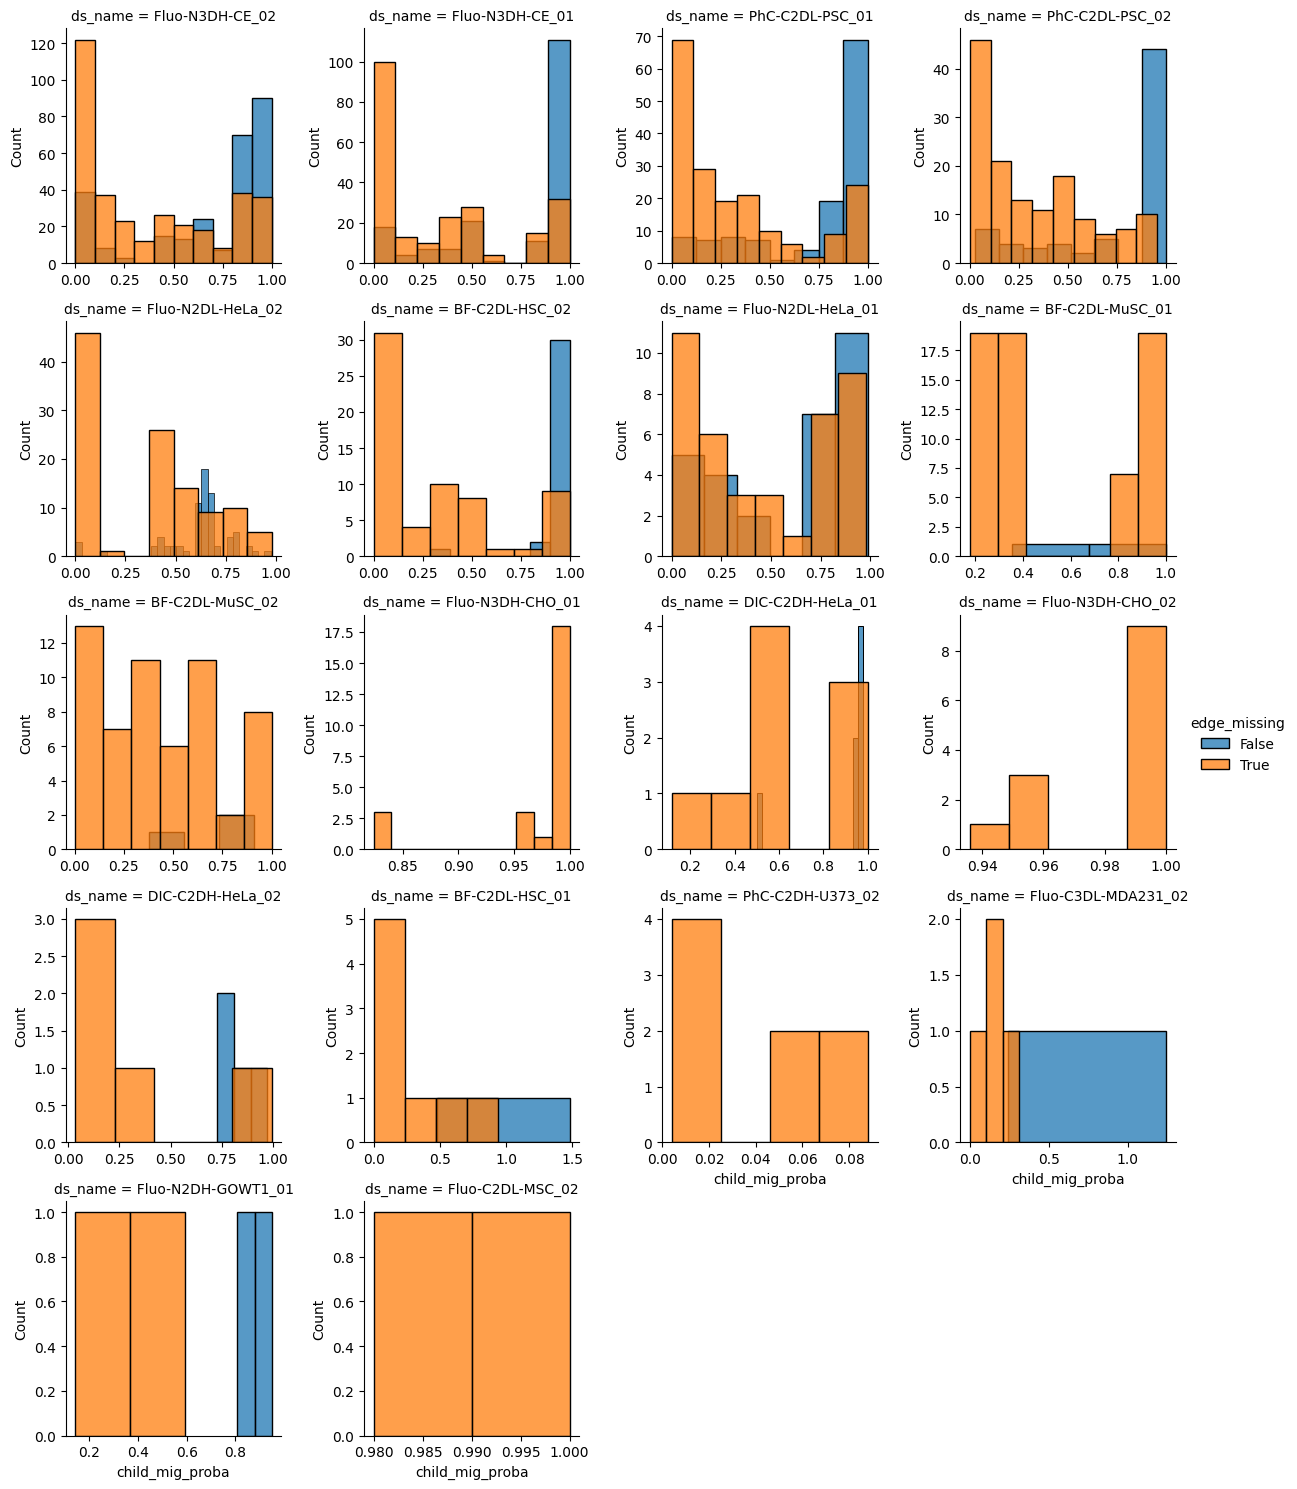

In [6]:
import seaborn as sns
plot_order = missing_div_df['ds_name'].value_counts().sort_values(ascending=False).index.tolist()
grid = sns.FacetGrid(missing_div_df, col='ds_name', col_order=plot_order, col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='edge_missing')
grid.map_dataframe(sns.histplot, x='child_mig_proba')
grid.add_legend()

In [7]:
count_edge_not_present

defaultdict(<function __main__.<lambda>()>,
            {'Fluo-C3DL-MDA231_02': 1,
             'Fluo-N2DH-GOWT1_01': 2,
             'PhC-C2DH-U373_01': 1,
             'PhC-C2DH-U373_02': 5,
             'Fluo-N2DL-HeLa_02': 8,
             'DIC-C2DH-HeLa_01': 1,
             'DIC-C2DH-HeLa_02': 3,
             'Fluo-N3DH-CHO_01': 10,
             'Fluo-N3DH-CHO_02': 6,
             'BF-C2DL-MuSC_01': 25,
             'BF-C2DL-MuSC_02': 3,
             'BF-C2DL-HSC_02': 2,
             'PhC-C2DL-PSC_01': 20,
             'PhC-C2DL-PSC_02': 3,
             'Fluo-N3DH-CE_01': 4,
             'Fluo-N3DH-CE_02': 3})

<Axes: xlabel='cost', ylabel='Count'>

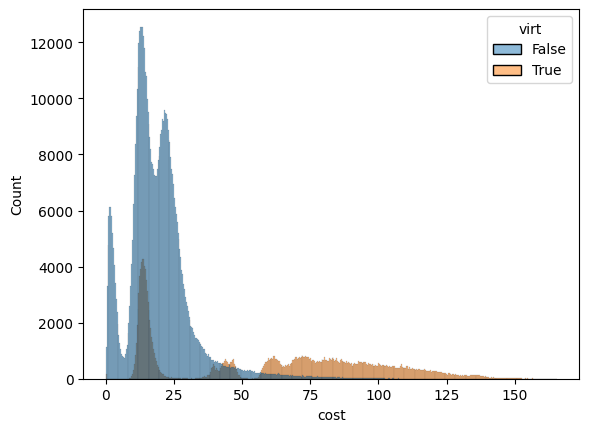

In [22]:
import seaborn as sns
ds_name_of_interest = 'BF-C2DL-HSC_02'
initial_all_edges = pd.read_csv(os.path.join(initial_root, ds_name_of_interest, OUT_FILE.ALL_EDGES.value))
initial_all_edges['virt'] = (initial_all_edges.u < 0) | (initial_all_edges.v < 0)
it_1_all_edges = pd.read_csv(os.path.join(iterative_root, ds_name_of_interest, f'{ds_name_of_interest}_it1', OUT_FILE.ALL_EDGES.value))
it_1_all_edges['virt'] = (it_1_all_edges.u < 0) | (it_1_all_edges.v < 0)

sns.histplot(initial_all_edges, x='cost', hue='virt')


<Axes: xlabel='model_cost', ylabel='Count'>

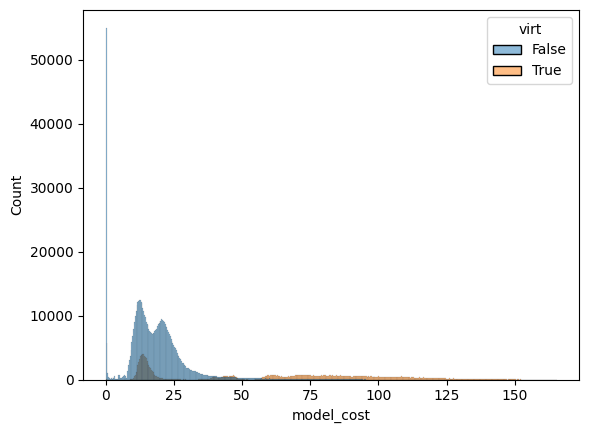

In [23]:
sns.histplot(it_1_all_edges, x='model_cost', hue='virt')


In [7]:
import networkx as nx
datasets = []
n_edges_in_model = []
n_edges_in_sol = []
for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_init_root = os.path.join(initial_root, ds_name)
    all_edges_before_it = pd.read_csv(os.path.join(ds_init_root, 'all_edges.csv'))
    sol = nx.read_graphml(os.path.join(ds_init_root, 'matched_solution.graphml'), node_type=int)
    datasets.append(ds_name)
    n_edges_in_model.append(len(all_edges_before_it))
    n_edges_in_sol.append(sol.number_of_edges())
n_edges_df = pd.DataFrame({
    'ds_name': datasets,
    'n_edges': n_edges_in_model,
    'n_edges_sol': n_edges_in_sol
})
print(n_edges_df.sort_values(by='n_edges', ascending=False))

                ds_name  n_edges  n_edges_sol
22      PhC-C2DL-PSC_01   916723        71252
19       BF-C2DL-HSC_02   823850        64503
23      PhC-C2DL-PSC_02   732599        56698
7     Fluo-N2DL-HeLa_02   325923        25173
24      Fluo-N3DH-CE_01   304898        23761
25      Fluo-N3DH-CE_02   285671        22197
6     Fluo-N2DL-HeLa_01   110332         8542
18       BF-C2DL-HSC_01    84514         8674
17      BF-C2DL-MuSC_02    78168         7266
16      BF-C2DL-MuSC_01    56532         5420
3    Fluo-N2DH-GOWT1_02    29458         2267
2    Fluo-N2DH-GOWT1_01    26484         2034
12     DIC-C2DH-HeLa_01    14156         1072
13     DIC-C2DH-HeLa_02    12504          952
14     Fluo-N3DH-CHO_01    10953          853
4      PhC-C2DH-U373_01     7361          757
1   Fluo-C3DL-MDA231_02     7084          529
15     Fluo-N3DH-CHO_02     6300          576
5      PhC-C2DH-U373_02     6262          680
8      Fluo-C2DL-MSC_01     5012          411
0   Fluo-C3DL-MDA231_01     4268  

In [9]:
starting_edge_errors

,ds_name,total_edge_errors
306,PhC-C2DL-PSC_01,2401
396,Fluo-N3DH-CE_02,1199
366,Fluo-N3DH-CE_01,838
336,PhC-C2DL-PSC_02,672
114,Fluo-N2DL-HeLa_02,543
230,BF-C2DL-MuSC_02,450
217,BF-C2DL-MuSC_01,334
40,Fluo-N2DH-GOWT1_02,280
84,Fluo-N2DL-HeLa_01,219
276,BF-C2DL-HSC_02,218
